#### Aaditya Vyas - Sprint 13 Project
* The taxi company "Sweet Lift" is seeking to attract more drivers to assist with peak hour taxi usage
* To properly staff taxi drivers, predictions need to be made to see how many orders for a taxi ride will be made
* The predictions for taxi ride orders need to be observed for the next hour based on provided data 

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.


## Preparation

In [84]:
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from catboost import CatBoostRegressor

import seaborn as sns
import matplotlib.pyplot as plt

## Analysis

In [85]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [87]:
df.isnull().sum()

num_orders    0
dtype: int64

In [88]:
df = df.resample('h').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [89]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<Axes: xlabel='datetime', ylabel='num_orders'>

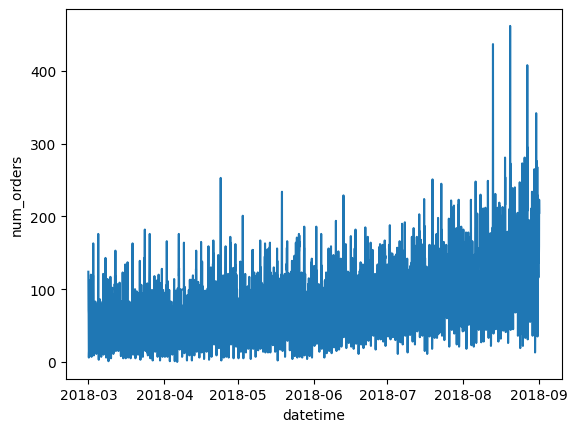

In [90]:
sns.lineplot(data=df['num_orders'])

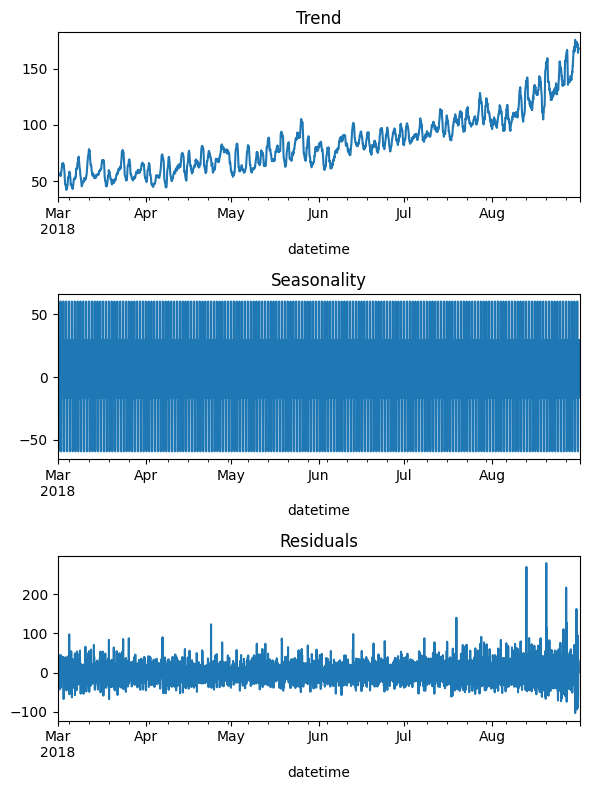

In [91]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Text(0.5, 1.0, '6 Hour Rolling Mean')

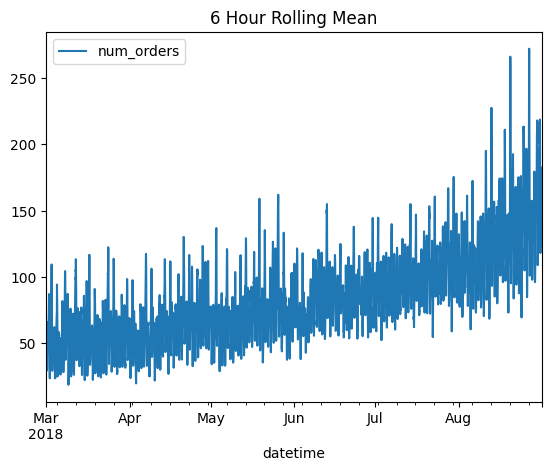

In [92]:
df.rolling(6).mean().plot()
plt.title('6 Hour Rolling Mean')

Text(0.5, 1.0, '24 Hour Rolling Mean')

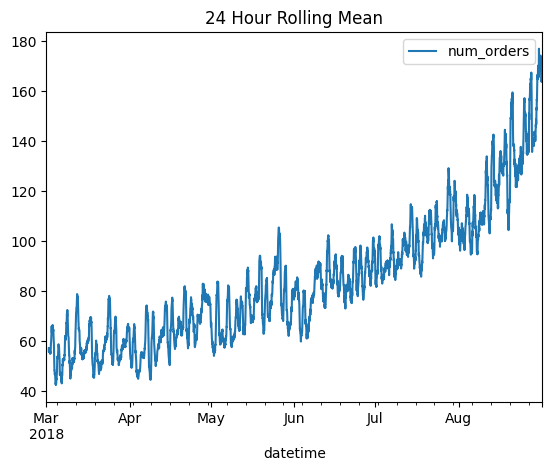

In [93]:
df.rolling(24).mean().plot()
plt.title('24 Hour Rolling Mean')

Text(0.5, 1.0, '168 Hour (Weekly) Rolling Mean')

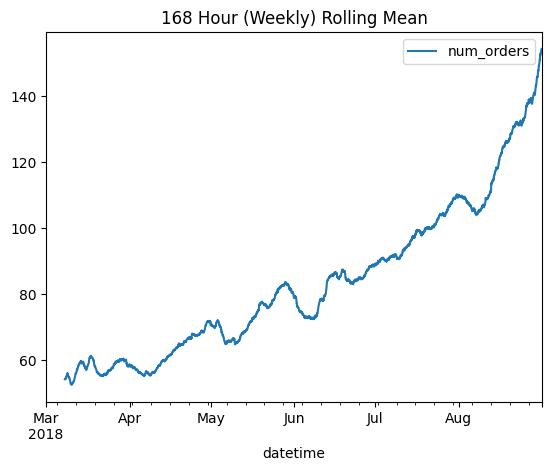

In [94]:
df.rolling(168).mean().plot()
plt.title('168 Hour (Weekly) Rolling Mean')

* The decomposition of this data shows a clear positive trend
* There does not appear to be too much seasonal fluctiation based on the initial creation of this graph
* Applying a weekly (168 hour) rolling mean creates a smoother trend

## Training - Make Features

* To help us understand the dataset and possible underlying trends, new features will be created
    * Dates have been separated into month, day, and day of the week
    * A lag criteria of 1 has been applied since we are observing hourly data
    * A rolling mean of 168 has shown to create a smooth trend as noted above 

In [95]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [96]:
make_features(df, 24, 168)

In [97]:
df.describe()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
count,4416.000000,4416.000000,4416.000000,4416.000000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,...,4400.000000,4399.000000,4398.000000,4397.000000,4396.000000,4395.000000,4394.000000,4393.000000,4392.000000,4248.000000
mean,84.422781,5.505435,15.836957,3.005435,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,...,84.095227,84.103887,84.115052,84.116443,84.074613,84.071217,84.038006,84.012975,83.969262,83.510491
std,45.023853,1.713306,8.855229,1.990684,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,...,44.733738,44.735135,44.734091,44.739084,44.658098,44.662612,44.613388,44.587597,44.498432,23.242653
min,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.559524
25%,54.000000,4.000000,8.000000,1.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,65.017857
50%,78.000000,5.500000,16.000000,3.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.098214
75%,107.000000,7.000000,23.250000,5.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,99.269345
max,462.000000,8.000000,31.000000,6.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,154.434524


## Training - Split Datasets
* Split datsets into training, validation, and testing subsets
* Training data must be 10% of total dataset per customer request (aka project instructions)

In [98]:
train_valid, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=12345)

In [99]:
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.3, random_state=12345)
train = train.dropna()

In [100]:
train

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,8,3,94.0,127.0,108.0,76.0,50.0,99.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,54.226190
2018-03-08 01:00:00,78,3,8,3,143.0,94.0,127.0,108.0,76.0,50.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,54.339286
2018-03-08 02:00:00,65,3,8,3,78.0,143.0,94.0,127.0,108.0,76.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,54.297619
2018-03-08 03:00:00,68,3,8,3,65.0,78.0,143.0,94.0,127.0,108.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,54.261905
2018-03-08 04:00:00,60,3,8,3,68.0,65.0,78.0,143.0,94.0,127.0,...,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,54.273810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-24 16:00:00,154,6,24,6,122.0,107.0,42.0,74.0,51.0,60.0,...,127.0,111.0,90.0,59.0,66.0,81.0,44.0,88.0,140.0,84.523810
2018-06-24 17:00:00,103,6,24,6,154.0,122.0,107.0,42.0,74.0,51.0,...,64.0,127.0,111.0,90.0,59.0,66.0,81.0,44.0,88.0,84.511905
2018-06-24 18:00:00,51,6,24,6,103.0,154.0,122.0,107.0,42.0,74.0,...,59.0,64.0,127.0,111.0,90.0,59.0,66.0,81.0,44.0,84.386905


In [101]:
valid

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-24 21:00:00,105,6,24,6,84.0,96.0,51.0,103.0,154.0,122.0,...,93.0,164.0,86.0,59.0,64.0,127.0,111.0,90.0,59.0,84.654762
2018-06-24 22:00:00,124,6,24,6,105.0,84.0,96.0,51.0,103.0,154.0,...,29.0,93.0,164.0,86.0,59.0,64.0,127.0,111.0,90.0,84.785714
2018-06-24 23:00:00,100,6,24,6,124.0,105.0,84.0,96.0,51.0,103.0,...,22.0,29.0,93.0,164.0,86.0,59.0,64.0,127.0,111.0,85.125000
2018-06-25 00:00:00,154,6,25,0,100.0,124.0,105.0,84.0,96.0,51.0,...,64.0,22.0,29.0,93.0,164.0,86.0,59.0,64.0,127.0,85.113095
2018-06-25 01:00:00,119,6,25,0,154.0,100.0,124.0,105.0,84.0,96.0,...,94.0,64.0,22.0,29.0,93.0,164.0,86.0,59.0,64.0,84.946429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,8,13,0,91.0,39.0,66.0,83.0,143.0,168.0,...,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,113.821429
2018-08-13 10:00:00,156,8,13,0,137.0,91.0,39.0,66.0,83.0,143.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,113.827381
2018-08-13 11:00:00,144,8,13,0,156.0,137.0,91.0,39.0,66.0,83.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,114.017857


In [102]:
test

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,8,13,0,119.0,92.0,144.0,156.0,137.0,91.0,...,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,104.0,114.214286
2018-08-13 15:00:00,175,8,13,0,102.0,119.0,92.0,144.0,156.0,137.0,...,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,114.238095
2018-08-13 16:00:00,144,8,13,0,175.0,102.0,119.0,92.0,144.0,156.0,...,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,114.583333
2018-08-13 17:00:00,152,8,13,0,144.0,175.0,102.0,119.0,92.0,144.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,114.226190
2018-08-13 18:00:00,104,8,13,0,152.0,144.0,175.0,102.0,119.0,92.0,...,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,114.339286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,154.297619
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,154.434524
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,154.285714


In [103]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [104]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(2613, 28)
(2613,)
(1193, 28)
(1193,)
(442, 28)
(442,)


## Training - Model Creation
* With all datsets split up, we can now create models to test RSME values

### Decision Tree

In [105]:
d_tree_results = []

for depth in range(1, 25):
    d_tree = DecisionTreeRegressor(random_state = 12345, max_depth=depth)
    d_tree.fit(features_train, target_train)
    predicted_d_tree = d_tree.predict(features_valid)
    d_tree_rsme = mean_squared_error(target_valid, predicted_d_tree)**0.5
    d_tree_results.append({
        'Depth':depth,
        'RSME': d_tree_rsme,
    })

In [106]:
d_tree_results_df = pd.DataFrame(d_tree_results)
d_tree_results_df.sort_values(by='RSME', ascending=True)

,Depth,RSME
2,3,36.986239
5,6,37.059392
4,5,37.406851
6,7,37.941068
3,4,38.433481
7,8,38.960382
1,2,40.318901
8,9,41.090228
10,11,41.201149
18,19,41.627984


### Random Forest

In [107]:
rf_results = []

for estimators in range(1, 70):
    random_forest = RandomForestRegressor(random_state = 12345, n_estimators=estimators)
    random_forest.fit(features_train, target_train)
    predicted_rf = random_forest.predict(features_valid)
    rf_rsme = mean_squared_error(target_valid, predicted_rf)**0.5
    rf_results.append({
        'Estimators':estimators,
        'RSME': rf_rsme,
    })

In [108]:
rf_results_df = pd.DataFrame(rf_results)
rf_results_df.sort_values(by='RSME', ascending=True)

,Estimators,RSME
68,69,31.960083
67,68,32.029512
66,67,32.031719
65,66,32.035454
35,36,32.040496
...,...,...
4,5,35.385978
3,4,36.627856
2,3,38.414833
1,2,41.411433


### Linear Regression

In [109]:
linear_reg = LinearRegression()
linear_reg.fit(features_train, target_train)

lr_predictions = linear_reg.predict(features_valid)
lr_rsme = mean_squared_error(target_valid, lr_predictions)**0.5

print('Linear Regression RSME: ', lr_rsme)

Linear Regression RSME:  31.15303779558399


### CatBoost

In [110]:
cb_model = CatBoostRegressor(iterations=150, random_seed=12345)
cb_model.fit(features_train, target_train, verbose=10)

cb_predict = cb_model.predict(features_valid)
cb_rsme = mean_squared_error(target_valid, cb_predict)**0.5

print('CatBoost RSME: ', cb_rsme)

Learning rate set to 0.222805
0:	learn: 30.7273286	total: 5.65ms	remaining: 842ms
10:	learn: 21.1909082	total: 61.7ms	remaining: 780ms
20:	learn: 19.4979632	total: 117ms	remaining: 721ms
30:	learn: 18.3351204	total: 156ms	remaining: 598ms
40:	learn: 17.6023563	total: 167ms	remaining: 445ms
50:	learn: 16.6240516	total: 178ms	remaining: 345ms
60:	learn: 15.7209789	total: 188ms	remaining: 275ms
70:	learn: 15.0204164	total: 200ms	remaining: 222ms
80:	learn: 14.3854971	total: 211ms	remaining: 180ms
90:	learn: 13.6483293	total: 221ms	remaining: 143ms
100:	learn: 13.0453048	total: 232ms	remaining: 113ms
110:	learn: 12.6113960	total: 242ms	remaining: 85.1ms
120:	learn: 12.1346383	total: 254ms	remaining: 60.8ms
130:	learn: 11.7266407	total: 264ms	remaining: 38.3ms
140:	learn: 11.1880206	total: 274ms	remaining: 17.5ms
149:	learn: 10.7611666	total: 284ms	remaining: 0us
CatBoost RSME:  32.624198714804024


## Testing

In [111]:
random_forest2 = RandomForestRegressor(random_state = 12345, n_estimators=69)
random_forest2.fit(features_train, target_train)
predicted_rf2 = random_forest2.predict(features_test)
rf_rsme2 = mean_squared_error(target_test, predicted_rf2)**0.5

print('Random Forest Tesing RSME: ', rf_rsme2)


Random Forest Tesing RSME:  56.12151588817553


## Testing Refinement
* Concatenate testing and validation data to try and achieve better results

In [113]:
features_train_valid2 = pd.concat([features_train, features_valid])
target_train_valid2 = pd.concat([target_train, target_valid])

In [114]:
random_forest3 = RandomForestRegressor(random_state = 12345, n_estimators=69)
random_forest3.fit(features_train_valid2, target_train_valid2)
predicted_rf3 = random_forest3.predict(features_test)
rf_rsme3 = mean_squared_error(target_test, predicted_rf3)**0.5

print('Random Forest Tesing RSME: ', rf_rsme3)

Random Forest Tesing RSME:  44.2515726342509


## Conclusion
* Random Forest regression yielded the best results on the training dataset with an RSME value of 35.461001. This value satisfied the requirment of an RSME under 48
* When compared against the testing datset, the RSME value was 40.500051
* To further refine results, the validation and testing dataframes (both targets and feagtures) were concatenated and then tested against the best model
* The result yielded a RSME of 44.2515726342509 
* The Random Forest model, with 69 estimators would be the best solution to select